In [1]:
from qutip import *
import numpy as np
import math, cmath
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
# ANCILLA
alpha = complex(1/math.sqrt(2), 0)
beta = complex(1/math.sqrt(2), 0)
phi = math.pi/6
phase = cmath.rect(1, phi)
# Ancilla State
eta = np.array([[abs(alpha)**2, 0                       , 0                      ], 
                [0       , abs(beta)**2/2               , abs(beta)**2/2*phase], 
                [0       , abs(beta)**2/2 * phase.conjugate(), beta**2/2              ]])
eta = Qobj(eta)
display(Markdown("## Ancillas State"))
display(eta)

## Ancillas State

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.5       +0.j    0.        +0.j    0.        +0.j   ]
 [0.        +0.j    0.25      +0.j    0.21650635+0.125j]
 [0.        +0.j    0.21650635-0.125j 0.25      +0.j   ]]

In [3]:
# SYSTEMS: Two qubit Systems, 1 and 2
def create_system(n_dims, dm_type, **kwargs):
    match dm_type:
        case 'coherent':
            alpha = kwargs.get('alpha') if 'alpha' in kwargs else 1
            return coherent_dm(n_dims, alpha)
        case 'thermal-enr':
            dims = n_dims if isinstance(n_dims, list) else list([n_dims]) 
            excitations = kwargs.get('excitations') if 'excitations' in kwargs else 1
            return enr_thermal_dm(dims,excitations,n=1)
        case 'thermal':
            return thermal_dm(n_dims, n=1)
        case 'fock':
            n = kwargs.get('n') if 'n' in kwargs else 0
            return fock_dm(n_dims, n)
        case 'maxmix':
            return maximally_mixed_dm(n_dims)
        case 'random':
            seed = kwargs.get('seed') if 'seed' in kwargs else 21
            return rand_dm(n_dims)
        case 'generic':
            a = kwargs.get('a') if 'a' in kwargs else complex(1, 0)
            b = kwargs.get('b') if 'b' in kwargs else complex(0, 0)
            return Qobj(np.array([[a, b], [b.conjugate(), 1-a]]))
            
s1 = create_system(2, 'fock')
display(Markdown("## System 1"))
display(s1)
s2 = create_system(2, 'fock')
display(Markdown("## System 2"))
display(s2)

## System 1

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

## System 2

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [4]:
# Ladder operators for the Systems
a1 = tensor(destroy(2),qeye(2))
a1d = tensor(create(2), qeye(2))
a2 = tensor(qeye(2), destroy(2))
a2d = tensor(qeye(2), create(2))

In [5]:
# Ladder Operators for the Ancilla
sigma1p = Qobj(np.array([[0, 1, 0], [0,0,0], [0,0,0]]))
sigma1m = Qobj(np.array([[0, 0, 0], [1,0,0], [0,0,0]]))
sigma2p = Qobj(np.array([[0, 0, 1], [0,0,0], [0,0,0]]))
sigma2m = Qobj(np.array([[0, 0, 0], [0,0,0], [1,0,0]]))

In [6]:
# System-Ancilla Interaction
omega = 10
Vn1 = omega * (tensor(a1, qeye(3)) * tensor(qeye(2), qeye(2), sigma1p+sigma2p) + (tensor(a1d, qeye(3)) * tensor(qeye(2), qeye(2), sigma1m+sigma2m)))
Vn2 = omega * (tensor(a2, qeye(3)) * tensor(qeye(2), qeye(2), sigma1p+sigma2p) + (tensor(a2d, qeye(3)) * tensor(qeye(2), qeye(2), sigma1m+sigma2m)))

In [11]:
# Time-evolution Operators during collitions
timedelta = 1e-2
Un1 = (-1j*Vn1*timedelta).expm()
Un2 = (-1j*Vn2*timedelta).expm()
Un1

Quantum object: dims = [[2, 2, 3], [2, 2, 3]], shape = (12, 12), type = oper, isherm = False
Qobj data =
[[ 0.99001666+0.j        0.        +0.j        0.        +0.j
   0.        +0.j        0.        +0.j        0.        +0.j
   0.        +0.j        0.        -0.099667j  0.        -0.099667j
   0.        +0.j        0.        +0.j        0.        +0.j      ]
 [ 0.        +0.j        1.        +0.j        0.        +0.j
   0.        +0.j        0.        +0.j        0.        +0.j
   0.        +0.j        0.        +0.j        0.        +0.j
   0.        +0.j        0.        +0.j        0.        +0.j      ]
 [ 0.        +0.j        0.        +0.j        1.        +0.j
   0.        +0.j        0.        +0.j        0.        +0.j
   0.        +0.j        0.        +0.j        0.        +0.j
   0.        +0.j        0.        +0.j        0.        +0.j      ]
 [ 0.        +0.j        0.        +0.j        0.        +0.j
   0.99001666+0.j        0.        +0.j        0.        +0.j


In [8]:
def evolve(rho, eta):
    op = tensor(rho, eta)
    first_evolution = Un1 * op * Un1.dag()
    final_evolution = Un2 * first_evolution * Un2.dag()
    # Trace off the Ancilla State
    systems_state = final_evolution.ptrace([0,1])
    return systems_state

In [12]:
# Initialize Total System array
rho12 = [tensor(s1, s2)]
# N time-step evolution of the Total System
for i in np.arange(1000):
    rho_new = evolve(rho12[-1], eta)
    rho12.append(rho_new)
    
# Single Systems evolution (partial-tracing off the other System and the Ancilla)
rho1 = np.array([rho.ptrace([0]) for rho in rho12])
rho2 = np.array([rho.ptrace([1]) for rho in rho12])
rho_new

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.30058816+0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.18208467+0.00000000e+00j
  0.14450826+0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.14450826+8.13151629e-20j
  0.1720943 +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.34523288+0.00000000e+00j]]

/home/fedesss/anaconda3/envs/qubit/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/fedesss/anaconda3/envs/qubit/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


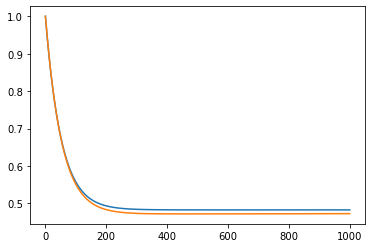

In [10]:
# Plot uppermost element of single Systems
plt.plot(rho1[:,0,0])
plt.plot(rho2[:,0,0])
plt.show()